# COMP41680 API Assignment 1
## Robert Keenan 15333066
### An Aviation API and Weather API

## Step 1: APIs
For the first API, I have chosen to use the Aviationstack API which is one of the largest and most utilised APIs for real time and historical flight data. I will use this in unison with a weather API which will be used to determine the correlation/relationship between the weather and flight's statuses at different airports. I will then further investigate whether the weather affects different airlines, routes or airplane models differently such as between a small regional jet and a large, long range jet such as the Boeing 777.
- The Aviationstack API can be found here: https://aviationstack.com
- The weather API can be found here at: TODO/FIXME

I will firstly import any libraries or packages needed and then make a start on the data collection stage of the assignment. 

Each API has thorough documentation on their websites detailing all of the endpoints available to a user, how to make an API request and how to tailor these requests for the information you need for your purpose.

### API 1: Aviationstack API 
I received an API key for my Aviationstack account which is given as b4a871dbf85b4f670dafbdc9615a68e9.
In terms of the Aviationstack API, a number of pieces of information can be gathered such as real-time or historical data, different routes, airports, planes, aircraft types and countries. All of these endpoints or pieces of information can be used to infer something from the data.
The Aviationstack API allows 500 free API requests a month and I chose this one over FlightAware as FlightAware charges for each request.

With the aviationstack API, each API call returns 100 flights using the "flights" endpoint which is determined by the "limit" of 100. Unfortunately the limit is 100 for the free and basic paid plans. I have the Free plan which allows you the 500 API calls a month, but I emailed the Customer Support team who were happy to give me a free upgrade to the Basic Plan for 2 weeks to complete the project which allows 10,000 calls a month as well as access to Historical flight data which would make my analysis a little easier. If I wanted to gather 300 items from the same endpoint, I would need to use the "offset" variable to move the starting point by 100 each time. This would mean I had 3 files.

These 3 JSON files will need to be cleaned and combined with each other to create one file. 


### API 2: World Weather Online API

FIXME TALK ABOUT THE WEATHER API



In [1]:
import os
import urllib.request
import fnmatch
import csv
import json
import pandas as pd 
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import requests
from gmplot import *
%matplotlib inline

In [89]:
params_departure_active = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'active',
    'airline_iata': 'BA',
}

params_departure_active_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'active',
    'min_delay_dep': '1',
    'airline_iata': 'BA',
}

params_departure_landed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'landed',
    'airline_iata': 'BA',
}

params_departure_landed_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'landed', 
    'min_delay_dep': '1',
    'airline_iata': 'BA',
}

params_arrival_landed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LHR',
    'flight_status': 'landed',
    'airline_iata': 'BA',
}

params_arrival_landed_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LHR',
    'flight_status': 'landed',
    'min_delay_arr': '1',
    'airline_iata': 'BA',
}

params_Dublin_Airport = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'DUB',
    'offset': '400',
    'flight_date': '2020-01-13'
}

params_NY_LA = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LAX',
    'dep_iata': 'JFK',
    'offset': '100',
    'flight_date': '2020-03-06'
}




#dept_active = requests.get('http://api.aviationstack.com/v1/flights', params_departure_active)
#dept_active_delay = requests.get('http://api.aviationstack.com/v1/flights', params_departure_active_delayed)
#dept_landed = requests.get('http://api.aviationstack.com/v1/flights', params_departure_landed)
#dept_landed_delayed = requests.get('http://api.aviationstack.com/v1/flights', params_departure_landed_delayed)
#arr_landed = requests.get('http://api.aviationstack.com/v1/flights', params_arrival_landed)
#arr_landed_delayed = requests.get('http://api.aviationstack.com/v1/flights', params_arrival_landed_delayed)
#Dublin_Airport = requests.get('http://api.aviationstack.com/v1/flights', params_Dublin_Airport)
#NY_to_LA = requests.get('http://api.aviationstack.com/v1/flights', params_NY_LA)

In this section, I will define the utility functions which will take the JSON data, parse into a file and then save these files in date specific formats.

In [90]:
#From here create a get data file which we will pass in the data to

#if response.status_code != 200:
    # This means something went wrong.
 #       print("Something went wrong")



def API_request_write_to_file(name_of_file, endpoint, params):
    if endpoint == 'flights':
        data = requests.get('http://api.aviationstack.com/v1/flights', params)
    elif endpoint == 'airports':
        data = requests.get('http://api.aviationstack.com/v1/airports', params)
    else:
        data = requests.get('http://api.aviationstack.com/v1/flights', params)
    now = datetime.now()
    dt_string = now.strftime("%d-%m_%H_%M")
    data_json = data.json()
    THIS_FOLDER = os.path.abspath(os.getcwd())
    new_file_name = os.path.join(THIS_FOLDER, str(name_of_file)+'_'+ str(dt_string) +'.json')
    with open(new_file_name, 'w+', encoding='utf-8') as new_json_file:
        json.dump(data_json, new_json_file, ensure_ascii=False, indent=4)



In [91]:
#create_write_to_files(dept_active, 'LHR_BA_dept_active')
#create_write_to_files(dept_active_delay, 'LHR_BA_dept_active_delay')
#create_write_to_files(dept_landed, 'LHR_BA_dept_landed')
#create_write_to_files(dept_landed_delayed, 'LHR_BA_dept_landed_delayed')
#create_write_to_files(arr_landed, 'LHR_BA_arr_landed')
#create_write_to_files(arr_landed_delayed, 'LHR_BA_arr_landed_delayed')
#create_write_to_files(Dublin_Airport, 'Dublin_Airport_arrivals_800')
#create_write_to_files(NY_to_LA, 'JFK_to_LA_landed_5March')


#API_request_write_to_file('NY_all_LA_JFK_100_6thMarch', 'flights', params_NY_LA)
API_request_write_to_file('Dublin_brendan_dept_400_13thJan', 'flights', params_Dublin_Airport)

From here, I need to do the weather API and also be able to parse the data to see if I can see the relationships. In terms of data that is delayed and not delayed in terms of the files, I can check to see if the files are common and just take the delayed ones out that are currently in the file, if not add them

## Case 1: Dublin Airport's Routes
In this case, I decided to use the aviationstack API to find out the most popular routes and airlines into and out of Dublin Airport on the 5th of March 2020. In this case, the real time flights endpoint will provide with all of the flights in a day. I used the parameters of "flight_status": "landed", "dep_iata": "DUB" and obviously, I needed "offset" to iterate through the results as I am limited to 100 results per API call. DUB is the IATA code of Dublin Airport. I could have used the ICAO code of EIDW either. In this case, I have obtained over 800 flights for departures which will need to be combined together before I can use the for analysis. 

### Step 1: Loading and cleaning API data
In terms of the aviationstack API data which is now stored in JSON file format. I will need to load it, normalize it into an appropriate data structure so that I can analyse the data. Each flight or item in an API request has a number of fields such as "departure", "arrival", "airline", "aircraft" and many more. Inside each of these fields is a lot more information such as IATA/ICAO codes, airport information and aircraft registrations. 

However, the majority of this information is available to me in an API request but sometimes some of this information is returned as "null" such as the aircraft model type and its registration which is more than likely the most common. One of the fields, "live", is relegated for information about a live flight still in the air but I have preferred to use flights that have a status of "landed". As a result, it is up to me to load the data and clean it appropriately so that I can interpret the data properly without the effect of these redundant variables.

In other case that I need to consider is that codeshares between airlines can make the data awkward to deal with. In the case of a flight from Dublin to London Heathrow, the airline reported by the API request could be Qatar Airways which is a member of OneWorld Alliance with British Airways who actually operated the flight. As a result, I need to delete these codeshared flights if the original flight is also present in the API request. 

In [170]:
def combine_data_frames(start_filename):
    #This will count the number of files which use this preamble
    num_files = 0
    #Initialise list to store names
    file_matches = []
    for name in os.listdir('.'):
        if start_filename in name:
              file_matches.append(name)
            
    for index,file in enumerate(file_matches):
        with open(file, 'r') as file_to_join:
            data = json.load(file_to_join)
        #Normalizing the data
        normalized_data = json_normalize(data['data'])
        #If first iteration, create the data frame 
        if index == 0:
            data_frame = pd.DataFrame(normalized_data)
        else:
            data_frame_add = pd.DataFrame(normalized_data)
            data_frame = pd.concat([data_frame, data_frame_add], ignore_index=True, sort = True)
    return data_frame
    
    
# This codeshare function will check if the flight number is common in multiple places.
# If it is present in the codeshare section and the codeshare of the original flight number is present, 
# delete the other flight
def codeshare_flight_deletion(data_frame):
    #Takes in the data frame and looks at each of the flight_numbers and the
    flight_times = data_frame['departure.scheduled']
    flight_numbers = data_frame['flight.iata']
    codeshared_flight = data_frame['flight.codeshared.flight_iata']
    for index,num in enumerate(codeshared_flight):
        #Need to continually update the flight numbers
        #flight_numbers = data_frame['flight.iata']
        if num != 'nan' or num != None or num != 'NaN':
            for index_2, flight_num in enumerate(flight_numbers):
                #This checks that the flight number is the same and that the departure times are the same
                if num == flight_num.lower() and flight_times[index] == flight_times[index_2]:
                    data_frame.drop([index], axis = 0, inplace = True)
                    print("Codeshare Flight "+num+" has been deleted")
                    break
                else:
                    continue
        #There is a NaN for the codeshare so go through
        else:
            continue
    data_frame.reset_index(drop = True, inplace = True)
    return data_frame
  
def day_time_data(day_flight_data):
    date = day_flight_data['flight_date']
    midnight_6am = [date+'T00:01:00+00:00', date+'T06:00:00+00:00']
    six_12pm = [date+'T06:01:00+00:00', date+'T12:00:00+00:00']
    midday_6pm = [date+'T12:01:00+00:00', date+'T18:00:00+00:00']
    six_12am = [date+'T18:01:00+00:00', date+'T23:59:00+00:00']
    
    flights_1 = day_flight_data['departure.scheduled'].between(midnight_6am[0], midnight_6am[1], inclusive=True).value_counts()
    flights_2 = day_flight_data['departure.scheduled'].between(six_12pm[0], six_12pm[1], inclusive=True).value_counts()
    flights_3 = day_flight_data['departure.scheduled'].between(midday_6pm[0], midday_6pm[1], inclusive=True).value_counts()
    flights_4 = day_flight_data['departure.scheduled'].between(six_12am[0], six_12am[1], inclusive=True).value_counts()
    if True in flights_1:
        time_1 = flights_1[1]
    else:
        time_1 = 0
    if True in flights_2:
        time_2 = flights_2[1]
    else:
        time_2 = 0
    if True in flights_3:
        time_3 = flights_3[1]
    else:
        time_3 = 0
    if True in flights_4:
        time_4 = flights_4[1]
    else:
        time_4 = 0
    return time_1, time_2, time_3, time_4

In [171]:
DUB_data_1 = combine_data_frames('Dublin_biggest_departures_')

From here, I can normalize the JSON data to create a flat table and then use Pandas to convert to a 2D data structure. 

In [172]:
#I access the 'data' field as the other information is the pagination offsets and limits which are not needed

# There are a number of columns in the Data Frame and I need to see what these are and they are
# related to the pagination information about offsets. I need to remove these and then access the info inside
print(DUB_data_1.columns)



Index(['aircraft', 'aircraft.iata', 'aircraft.icao', 'aircraft.icao24',
       'aircraft.registration', 'airline.iata', 'airline.icao', 'airline.name',
       'arrival.actual', 'arrival.actual_runway', 'arrival.airport',
       'arrival.baggage', 'arrival.delay', 'arrival.estimated',
       'arrival.estimated_runway', 'arrival.gate', 'arrival.iata',
       'arrival.icao', 'arrival.scheduled', 'arrival.terminal',
       'arrival.timezone', 'departure.actual', 'departure.actual_runway',
       'departure.airport', 'departure.delay', 'departure.estimated',
       'departure.estimated_runway', 'departure.gate', 'departure.iata',
       'departure.icao', 'departure.scheduled', 'departure.terminal',
       'departure.timezone', 'flight.codeshared',
       'flight.codeshared.airline_iata', 'flight.codeshared.airline_icao',
       'flight.codeshared.airline_name', 'flight.codeshared.flight_iata',
       'flight.codeshared.flight_icao', 'flight.codeshared.flight_number',
       'flight.iata', '

I need to take account for the codeshared flights which are not valid in this case. After this, I can delete the data columns which are not needed. 

In [173]:
print("Number of flights in data structure: "+ str(DUB_data_1.shape[0]))

Number of flights in data structure: 534


In [174]:
#Running the Codeshare clean function which gets rid of the codeshared flights that have a flight already in the data
clean_DUB_data_1 = codeshare_flight_deletion(DUB_data_1)
clean_DUB_data_1.reset_index(drop=True, inplace=True)

Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight wx280 has been deleted
Codeshare Flight wx282 has been deleted
Codeshare Flight wx284 has been deleted
Codeshare Flight wx286 has been deleted
Codeshare Flight wx288 has been deleted
Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight ei230 has been deleted
Codeshare Flight ei232 has been deleted
Codeshare Flight ei236 has been deleted
Codeshare Flight ei238 has been deleted
Codeshare Flight ei246 has been deleted
Codeshare Flight ei248 has

Codeshare Flight ei604 has been deleted
Codeshare Flight ei608 has been deleted
Codeshare Flight ei610 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl936 has been deleted
Codeshare Flight kl932 has been deleted
Codeshare Flight ei610 has been deleted
Codeshare Flight ei608 has been deleted
Codeshare Flight kl932 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl938 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl932 has been deleted
Codeshare Flight kl936 has been deleted
Codeshare Flight kl932 has been deleted
Codeshare Flight kl936 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl938 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl936 has been deleted
Codeshare Flight kl932 has been deleted
Codeshare Flight wa934 has been deleted
Codeshare Flight kl936 has been deleted
Codeshare Flight kl938 has been deleted
Codeshare Flight ey42 has been deleted
C

In [175]:
#Printing to show that codeshared flights have been removed that have a flight number elsewhere
print("Number of flights after cleaning codeshared flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights after cleaning codeshared flights: 249


This shows that there are a lot of codeshare flights returned in a single API request with a total of 900 flights gathered but only 427 singular routes/flights. As a result, I have shown the effect that cleaning data has had as I could have concluded something incorrect about the data due to the sheer number of codeshare flights. 





In the case of the data currently, there is a lot of columns that I do not need. These include scheduled flight times, runways, terminal numbers, gate numbers, aircraft types and many more. These will be needed later but for the case of this initial test they will not. Hence, I will now get rid of these columns which were printed out before hand. 
I want to simplify the data frame for the following features:
- Departure Time
- Arrival Airport 
- Arrival IATA airport code
- Airline Name
- Airline IATA code


In [176]:
#Clean the data for the specific date
clean_DUB_data_1 = clean_DUB_data_1[clean_DUB_data_1['flight_date'] == '2020-03-05']
simplified_data = clean_DUB_data_1[['departure.scheduled', 'arrival.airport', 'arrival.iata', 'airline.name', 'airline.iata']]
print("Number of flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights: 249


I am now checking that the data returned to me is all present and doesn't have any NULL values

In [177]:
simplified_data.isnull().sum()

departure.scheduled    0
arrival.airport        0
arrival.iata           0
airline.name           0
airline.iata           0
dtype: int64

Now checking that the simplified data has been returned properly by plotting the first 10 flights

In [178]:
simplified_data[0:10]

,departure.scheduled,arrival.airport,arrival.iata,airline.name,airline.iata
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


As we can see from the readout above, the data headings/column headings are laid out in an inituitive way but it is not very presentable in that fashion. As a result, I can rename the columns as appropriate.

I am using a mappping to the headings as the pd.DataFrame.rename() function sometimes has trouble interpreting what you mean when you want to rename something

In [179]:
 map_headings = {simplified_data.columns[0]: 'Scheduled Departure Time', 
                 simplified_data.columns[1]: 'Destination Airport', 
                 simplified_data.columns[2]: 'Destination IATA Code', 
                 simplified_data.columns[3]: 'Airline Name',
                 simplified_data.columns[4]: 'Airline IATA Code'}
                 
simplified_data = simplified_data.rename(columns=map_headings)
simplified_data[0:10]



,Scheduled Departure Time,Destination Airport,Destination IATA Code,Airline Name,Airline IATA Code
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


After the data has been cleaned appropriately as it has been above for just the destination airport and the airline to that destination airport. I can present the most popular destination airports for flights out of Dublin Airport on the 5th of March 2020 and airlines for those routes.
I will firstly characterise the Top 10 most popular airports for clarity

Text(0, 0.5, 'Number of Flights')

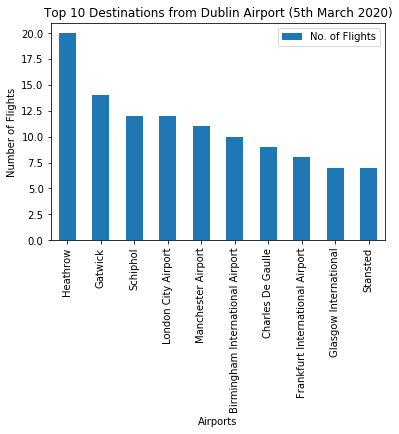

In [180]:
top_10_airport_numbers = simplified_data["Destination Airport"].value_counts()[0:10]
#Need to turn into a data frame to plot 
most_popular_airports = pd.DataFrame(top_10_airport_numbers)
most_popular_airports = most_popular_airports.rename(columns={'Destination Airport': 'No. of Flights'})
most_popular_airports_plot = most_popular_airports.plot(kind = 'bar', 
                                                        title="Top 10 Destinations from Dublin Airport (5th March 2020)")
most_popular_airports_plot.set_xlabel("Airports")
most_popular_airports_plot.set_ylabel("Number of Flights")

In [181]:
top_10_airport_numbers

Heathrow                            20
Gatwick                             14
Schiphol                            12
London City Airport                 12
Manchester Airport                  11
Birmingham International Airport    10
Charles De Gaulle                    9
Frankfurt International Airport      8
Glasgow International                7
Stansted                             7
Name: Destination Airport, dtype: int64

Getting the most common airports, I will need to store the most popular airports before then using the search parameter from the API documentation to find the airport before getting their longitude and latitude and plotting them.
I can use the IATA codes which will be unique for each airport and make sure that there are no changes


In [182]:
IATA_codes_most_popular = simplified_data["Destination Airport"].value_counts()[0:10]
list_of_airports = IATA_codes_most_popular.index.tolist()
list_of_airports

['Heathrow',
 'Gatwick',
 'Schiphol',
 'London City Airport',
 'Manchester Airport',
 'Birmingham International Airport',
 'Charles De Gaulle',
 'Frankfurt International Airport',
 'Glasgow International',
 'Stansted']

In [183]:
airport_locs = np.empty((0,3), int)

#for index,name in enumerate(list_of_airports):
    #param_airport = {'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9', 'search': name}
    #airport_data = requests.get('http://api.aviationstack.com/v1/airports', param_airport)
    #data_json = airport_data.json()
    ##longitude = data_json['data'][0]['longitude']
    #latitude = data_json['data'][0]['latitude']
    #name = data_json['data'][0]['airport_name']
    #airport_locs = np.append(airport_locs, np.array([[name, latitude, longitude]]), axis=0)        

I needed to do this as the API request for flights only gives you the the airport name and codes rather than their location

In [184]:
airport_locs

array([], shape=(0, 3), dtype=int64)

In [185]:
gmap = gmplot.GoogleMapPlotter(48.8566, 2.3522,0) #FIXME put a proper 

In [186]:
for location_info in airport_locs:
    name = location_info[0]
    location_info = location_info[1:]
    lat_lon = location_info.astype(float)
    #I need to do this as this is in terms of a NumPy data type rather than a native Python data type which gmap needs
    lat_temp, lon_temp = lat_lon[0], lat_lon[1]
    lat = lat_temp.item()
    lon = lon_temp.item()
    gmap.marker(lat, lon, 'cornflowerblue')

gmap.draw("airport_map.html")

In [187]:
os.system('airport_map.html')

32512

### Most Common Airports and the Airlines that serve them
From here on I need to look at the most common locations, the most common airlines and the most


Text(0, 0.5, 'Number of Flights')

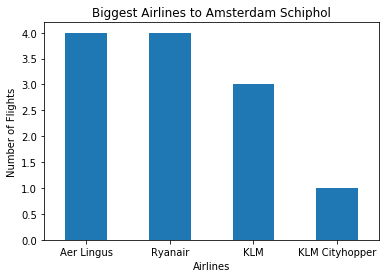

In [188]:
most_popular_airlines_airport = simplified_data.groupby('Destination Airport')
Total_Airports = most_popular_airlines_airport.sum()
Total_Airports = Total_Airports.sort_values('Airline Name', ascending = False)
#most_pop_airlines_for_airport = Total_Airports.plot(kind='bar')
#for key, item in most_popular_airlines_airport:
 #   print(most_popular_airlines_airport.get_group(key), "\n\n")
airport = list_of_airports[2]
airlines_at_airport = most_popular_airlines_airport.get_group(airport)
plot = airlines_at_airport['Airline Name'].value_counts().plot(kind='bar', 
                                                        title='Biggest Airlines to Amsterdam Schiphol', rot=0)
plot.set_xlabel("Airlines")
plot.set_ylabel("Number of Flights")

FIXME talk about how running the API at certain times has an effect and how some of the flights still say scheduled mainly because they are american flights and by the time they land and then the API updates with information, the flight will not be updated or landed yet

In the section below, I will look at the busiest terminals in a day followed by the most common times that these terminals are accessed

In [189]:
terminal_data = clean_DUB_data_1[['departure.scheduled','flight_date', 'departure.terminal', 'arrival.airport',\
                                  'arrival.iata', 'airline.name', 'airline.iata']]

In [190]:
#This just checks that none of the data is missing for terminal etc
terminal_data.isnull().sum()

departure.scheduled    0
flight_date            0
departure.terminal     0
arrival.airport        0
arrival.iata           0
airline.name           0
airline.iata           0
dtype: int64

In [191]:
terminals = terminal_data['departure.terminal'].value_counts()
#On the 5th of March 2020
print("Number of Terminal 1 Departures: %d flights\nNumber of Terminal 2 Departures: %d flights" 
      % (terminals.iloc[0], terminals.iloc[1]))

Number of Terminal 1 Departures: 146 flights
Number of Terminal 2 Departures: 103 flights


From here, I need to see what airlines depart from which terminals and then see the busier times such as how many flights leave between each time from each terminal. I could group them between each time like a column for 0-6am, 6-12pm, 12-6pm  and then 6-12am. 

Text(0, 0.5, 'Number of Flights')

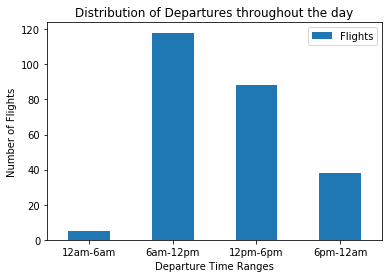

In [192]:
#Needs to be given in format of the following
#FIXME this will need to be changed for flight_date

midnight, six_am, midday, six_pm = day_time_data(terminal_data)

flights_times = pd.DataFrame({'Flights': [midnight, six_am,midday, six_pm]}, \
                             index = ['12am-6am', '6am-12pm', '12pm-6pm', '6pm-12am'])

plot = flights_times.plot(kind='bar', title='Distribution of Departures throughout the day', rot=0)
plot.set_xlabel("Departure Time Ranges")
plot.set_ylabel("Number of Flights")


In [193]:
#Verifying the total number of flights is the same
flights_times.sum()

Flights    249
dtype: int64

In [194]:
flights_times

,Flights
12am-6am,5
6am-12pm,118
12pm-6pm,88
6pm-12am,38


FIXME Next Step to do is to see what airlines take off between each time, so we will do the top 5 airlines as the x ticks and then have the 4 different plots for the different times that they take off at

In [195]:
#Get the most common airlines first
top_airlines = terminal_data["airline.name"].value_counts()[0:2]
top_airlines  = top_airlines.index.tolist()
top_airlines
#Now that I have the top airlines, I can see when they are using each time

['Ryanair', 'Aer Lingus']

Text(0, 0.5, 'Number of Flights')

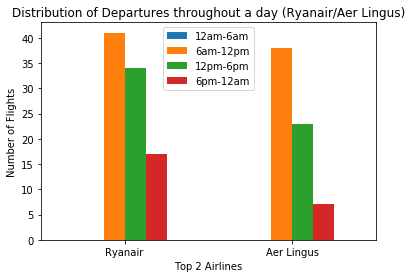

In [196]:
#terminal_data[flights_1[flights_1 == (True)]]
#I now need to get the airlines for thi
########
################################################################################################
################################################################################################
################################################################################################
# FIXXXXMMMEEEEEE MAKE THIS WAY SHORTER AS IT IS OBNOXIOUS TO LOOK AT. FIX WHEN I AM DONE
################################################################################################
################################################################################################
midnight_6am = ['2020-03-05T00:01:00+00:00', '2020-03-05T06:00:00+00:00']
six_12pm = ['2020-03-05T06:01:00+00:00', '2020-03-05T12:00:00+00:00']
midday_6pm = ['2020-03-05T12:01:00+00:00', '2020-03-05T18:00:00+00:00']
six_12am = ['2020-03-05T18:01:00+00:00', '2020-03-05T23:59:00+00:00']

flights_1 = terminal_data['departure.scheduled'].between(midnight_6am[0], midnight_6am[1], inclusive=True)
flights_2 = terminal_data['departure.scheduled'].between(six_12pm[0], six_12pm[1], inclusive=True)
flights_3 = terminal_data['departure.scheduled'].between(midday_6pm[0], midday_6pm[1], inclusive=True)
flights_4 = terminal_data['departure.scheduled'].between(six_12am[0], six_12am[1], inclusive=True)

#These are the indexes of the flights that leave inside of these times
midnight_flights = (flights_1[flights_1 == (True)]).index.tolist()
six_am_flights = (flights_2[flights_2 == (True)]).index.tolist()
midday_flights = (flights_3[flights_3 == (True)]).index.tolist()
six_pm_flights = (flights_4[flights_4 == (True)]).index.tolist()

#FIXME , look for a better way to do this
airline_1_12am = terminal_data.iloc[midnight_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_12am = terminal_data.iloc[midnight_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_6am = terminal_data.iloc[six_am_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_6am = terminal_data.iloc[six_am_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_12pm = terminal_data.iloc[midday_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_12pm = terminal_data.iloc[midday_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_6pm = terminal_data.iloc[six_pm_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_6pm = terminal_data.iloc[six_pm_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])

airline_times = pd.DataFrame({'12am-6am': [airline_1_12am, airline_2_12am], '6am-12pm': [airline_1_6am, airline_2_6am],
                             '12pm-6pm': [airline_1_12pm, airline_2_12pm], '6pm-12am': [airline_1_6pm, airline_2_6pm]}, 
                             index = ['Ryanair', 'Aer Lingus'])
plot = airline_times.plot(kind='bar', title = 'Distribution of Departures throughout a day (Ryanair/Aer Lingus)', rot=0)
plot.set_xlabel("Top 2 Airlines")
plot.set_ylabel("Number of Flights")

In [197]:
airline_times.describe()
#FIXME

,12am-6am,6am-12pm,12pm-6pm,6pm-12am
count,2.0,2.00000,2.000000,2.000000
mean,0.0,39.50000,28.500000,12.000000
std,0.0,2.12132,7.778175,7.071068
min,0.0,38.00000,23.000000,7.000000
25%,0.0,38.75000,25.750000,9.500000
50%,0.0,39.50000,28.500000,12.000000
75%,0.0,40.25000,31.250000,14.500000
max,0.0,41.00000,34.000000,17.000000


In [198]:
airline_times

,12am-6am,6am-12pm,12pm-6pm,6pm-12am
Ryanair,0,41,34,17
Aer Lingus,0,38,23,7


Text(0, 0.5, 'Number of Flights')

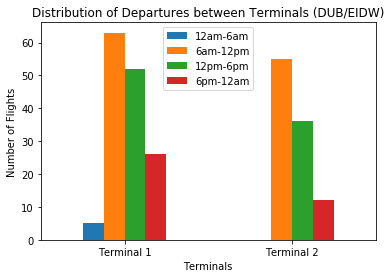

In [199]:
terminal_1_12am = terminal_data.iloc[midnight_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_12am = terminal_data.iloc[midnight_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_6am = terminal_data.iloc[six_am_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_6am = terminal_data.iloc[six_am_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_12pm = terminal_data.iloc[midday_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_12pm = terminal_data.iloc[midday_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_6pm = terminal_data.iloc[six_pm_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_6pm = terminal_data.iloc[six_pm_flights]['departure.terminal'].iloc[0:].tolist().count('2')


terminal_times = pd.DataFrame({'12am-6am': [terminal_1_12am, terminal_2_12am], '6am-12pm': [terminal_1_6am, terminal_2_6am],
                             '12pm-6pm': [terminal_1_12pm, terminal_2_12pm], '6pm-12am': [terminal_1_6pm, terminal_2_6pm]}, 
                              index = ['Terminal 1', 'Terminal 2'])
plot = terminal_times.plot(kind='bar', title = 'Distribution of Departures between Terminals (DUB/EIDW)', rot=0)
plot.set_xlabel("Terminals")
plot.set_ylabel("Number of Flights")

FIXME, FIND THE CORERLATION OR PLOT THE CORRELATION BETWEEN THE TERMINAL 1 and TERMINAL 2 data


Well now that I have found which are the busiest terminals,
Now i can do the legacy carriers in the US

### Legacy carriers in the USA
A common argument seen in the media is which is the most reliable airline of the 3 main US legacy carriers: United Airlines (UA), American Airlines (AA) and Delta Airlines (DL). One of the most competitive routes in the US for these 3 airlines is the perennial New York to Los Angeles route on which the airport slots are most expensive and cater mainly to business travelers between the 2 largest cities in the US who need reliability, consistency and a high frequency of flights per day. 

As a result, I will gather data for one week between New York and LA for the 3 legacy carriers as well as the young competitor, JetBlue. 
This involved taking data for flights that had a flight status of 'landed' according to the API between New York JFK(for American, Delta & JetBlue) and Newark Liberty Intl. (for United) to LAX. 

I will be able to study the frequency of the flights, the times at which these flights are served and how reliable they are in terms of on-time departures out of New York, especially the morning flights for business travelers.
I collected all of the departure data for these airlines between the 2nd and 6th of March 2020 inclusive.


In [200]:
us_legacy_carriers = combine_data_frames('NY_to_LA_')

I then need to check for codeshares and get rid of them


In [201]:
print('Current Number of Flights between New York and LA: %d' % (us_legacy_carriers.shape[0]))

Current Number of Flights between New York and LA: 483


In [202]:
us_legacy_carriers = codeshare_flight_deletion(us_legacy_carriers)
us_legacy_carriers.reset_index(drop=True, inplace=True)

Codeshare Flight dl2346 has been deleted
Codeshare Flight dl1529 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight b61823 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight aa255 has been deleted
Codeshare Flight aa171 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight aa331 has been deleted
Codeshare Flight aa1 has been deleted
Codeshare Flight aa185 has been deleted
Codeshare Flight b6123 has been deleted
Codeshare Flight b6323 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight dl2346 has been deleted
Codeshare Flight b6323 has been deleted
Codeshare Flight b6123 has been deleted
Codeshare Flight b61823 has been deleted
Codeshare Flight b623 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight aa185 has been 

Codeshare Flight aa1 has been deleted
Codeshare Flight aa331 has been deleted
Codeshare Flight b623 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1529 has been deleted
Codeshare Flight dl2346 has been deleted
Codeshare Flight dl1529 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight dl2346 has been deleted
Codeshare Flight ua240 has been deleted
Codeshare Flight ua703 has been deleted
Codeshare Flight ua240 has been deleted
Codeshare Flight ua703 has been deleted
Codeshare Flight ua275 has been deleted
Codeshare Flight as221 has been deleted
Codeshare Flight as221 has been deleted
Codeshare Flight as343 has been deleted
Codeshare Flight ua275 has been deleted
Codeshare Flight ua2158 has been deleted
Codeshare Flight ua1460 has been deleted
Codeshare Flight ua275 has been deleted
Codeshare Flight ua2394 has been de

In [203]:
print('Number of Flights after codeshares removed: %d' % (us_legacy_carriers.shape[0]))

Number of Flights after codeshares removed: 131


I will first check whether any of the airline names are null before checking to see what airlines are listed as flying between the airports and I will remove the ones I do not need

In [204]:
us_legacy_carriers['airline.name'].isnull().sum()

0

In [205]:
us_legacy_carriers['airline.name'].value_counts()

American Airlines    32
JetBlue Airways      31
Delta Air Lines      26
United Airlines      23
Alaska Airlines      17
Qantas                1
FedEx                 1
Name: airline.name, dtype: int64

From here, I can see that American Airlines is the largest carrier between the 3 legacy carriers by more than 6 flights per week than Delta and 9 flights more than United. JetBlue, being the younger competitor, has only one flight less per week on this important and expensive route and hence, I will need to include it in my analysis as it is very significant. 

In [206]:
chosen_airlines = us_legacy_carriers[['departure.scheduled','flight_date', 'airline.name', 'departure.airport', 'departure.delay', 'arrival.delay']]

As I can see below, I have access to all of the flight's in one business week, their dates, times, departure airport and their delays.

In [207]:
chosen_airlines

,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay
0,2020-03-04T07:30:00+00:00,2020-03-04,American Airlines,John F Kennedy International,NaN,NaN
1,2020-03-04T06:00:00+00:00,2020-03-04,American Airlines,John F Kennedy International,NaN,NaN
2,2020-03-04T21:30:00+00:00,2020-03-04,American Airlines,John F Kennedy International,NaN,10
3,2020-03-04T09:00:00+00:00,2020-03-04,American Airlines,John F Kennedy International,NaN,NaN
4,2020-03-04T20:30:00+00:00,2020-03-04,American Airlines,John F Kennedy International,NaN,NaN
...,...,...,...,...,...,...
126,2020-03-02T09:50:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN
127,2020-03-02T07:00:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN
128,2020-03-02T08:05:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,2
129,2020-03-02T11:40:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN


In [208]:
#Can sort the values in chronological order
#Ignore index doesnt work for some reason

chosen_airlines = chosen_airlines.sort_values(by='departure.scheduled', ascending=True)
chosen_airlines.reset_index(drop=True,inplace=True)
chosen_airlines


,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay
0,2020-03-02T05:35:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN
1,2020-03-02T06:00:00+00:00,2020-03-02,American Airlines,John F Kennedy International,NaN,NaN
2,2020-03-02T06:59:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN
3,2020-03-02T07:00:00+00:00,2020-03-02,United Airlines,Newark Liberty International,NaN,NaN
4,2020-03-02T07:00:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN
...,...,...,...,...,...,...
126,2020-03-06T11:00:00+00:00,2020-03-06,American Airlines,John F Kennedy International,None,None
127,2020-03-06T11:05:00+00:00,2020-03-06,United Airlines,Newark Liberty International,None,NaN
128,2020-03-06T11:30:00+00:00,2020-03-06,Alaska Airlines,John F Kennedy International,None,None
129,2020-03-06T11:40:00+00:00,2020-03-06,Delta Air Lines,John F Kennedy International,None,None


Now that I have the flights for the week, I can filter out Alaska Airlines

In [209]:
us_airlines_remove = chosen_airlines[(chosen_airlines['airline.name'] == 'Qantas') | \
                                     (chosen_airlines['airline.name'] == 'FedEx') | \
                                     (chosen_airlines['airline.name'] == 'Alaska Airlines')].index
# Delete these row indexes from dataFrame
chosen_airlines.drop(us_airlines_remove , inplace=True)
chosen_airlines.reset_index(drop=True, inplace=True)
chosen_airlines

,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay
0,2020-03-02T05:35:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN
1,2020-03-02T06:00:00+00:00,2020-03-02,American Airlines,John F Kennedy International,NaN,NaN
2,2020-03-02T06:59:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN
3,2020-03-02T07:00:00+00:00,2020-03-02,United Airlines,Newark Liberty International,NaN,NaN
4,2020-03-02T07:00:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN
...,...,...,...,...,...,...
107,2020-03-06T09:50:00+00:00,2020-03-06,Delta Air Lines,John F Kennedy International,None,None
108,2020-03-06T11:00:00+00:00,2020-03-06,American Airlines,John F Kennedy International,None,None
109,2020-03-06T11:05:00+00:00,2020-03-06,United Airlines,Newark Liberty International,None,NaN
110,2020-03-06T11:40:00+00:00,2020-03-06,Delta Air Lines,John F Kennedy International,None,None


From here, I can examine the distribution of flights throughout the week at different times. I will use the x axis as the days and the y axis as the number of flights

Text(0, 0.5, 'Number of Flights')

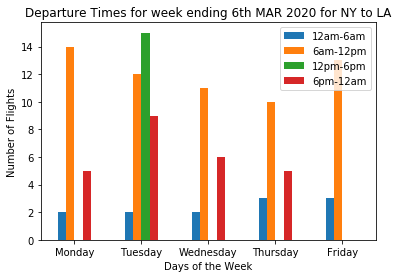

In [210]:
#FIXME implement in a function
monday    = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-02']
tuesday   = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-03']
wednesday = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-04']
thursday  = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-05']
friday    = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-06']

mon_12am, mon_6am, mon_12pm, mon_6pm = day_time_data(monday)
tue_12am, tues_6am, tues_12pm, tues_6pm = day_time_data(tuesday)
wed_12am, wed_6am, wed_12pm, wed_6pm = day_time_data(wednesday)
thur_12am, thur_6am, thur_12pm, thur_6pm = day_time_data(thursday)
fri_12am, fri_6am, fri_12pm, fri_6pm = day_time_data(friday)


#What i want to do is print each day to a data frame like below but for each day, there is
midnight_df = [mon_12am, tue_12am, wed_12am, thur_12am, fri_12am]
six_am_df = [mon_6am, tues_6am, wed_6am, thur_6am, fri_6am]
midday_df = [mon_12pm, tues_12pm, wed_12pm, thur_12pm, fri_12pm]
six_pm_df = [mon_6pm, tues_6pm, wed_6pm, thur_6pm, fri_6pm]

NY_to_LA_times = pd.DataFrame({'12am-6am': midnight_df, '6am-12pm': six_am_df, \
                               '12pm-6pm': midday_df, '6pm-12am': six_pm_df}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

NY_plot = NY_to_LA_times.plot(kind='bar', title = 'Departure Times for week ending 6th MAR 2020 for NY to LA',\
                           rot=0)
NY_plot.set_xlabel("Days of the Week")
NY_plot.set_ylabel("Number of Flights")




As we can see above, the flight data for a lot of the afternoon flights is missing. This could be due to the API not refreshing in time and as a result, it loses the data or perhaps the API no longer has access to the aircraft's inflight location for safety and security reasons which is the case in the USA. A lot of these API's and websites like FlightRadar24 use ADS-B receivers where the aircraft periodically broadcasts its location via satellite. These transponders are sometimes turned off on long journeys. 
Hence, I will now repeat the analysis above but for all flights regardless of their 'flight_status' such as 'active' or 'scheduled'. I will need to filter out cancelled flights. 

As a result below, I will gather the data for any possible flight status which will be saved to a file

In [211]:
all_legacy_carrier_flights = combine_data_frames('NY_all_LA_')

In [212]:
print('Total Number of Flights gathered: %d' %(all_legacy_carrier_flights.shape[0]))

Total Number of Flights gathered: 1043


In [213]:
#From here, I will now need to clean the codeshares
all_legacy_carrier_flights = codeshare_flight_deletion(all_legacy_carrier_flights)
all_legacy_carrier_flights.reset_index(drop=True, inplace=True)

Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl2346 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight dl1529 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight b61823 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight aa302 has been deleted
Codeshare Flight aa306 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight dl427 has been deleted
Codeshare Flight aa255 has been deleted
Codeshare Flight aa341 has been deleted
Codeshare Flight aa171 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight aa331 has been deleted
Codeshare Flight aa302 has been deleted
Codeshare Flight aa117 has been d

Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight dl453 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight b61823 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight aa302 has been deleted
Codeshare Flight aa306 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight dl427 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight aa255 has been deleted
Codeshare Flight aa341 has been deleted
Codeshare Flight aa171 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight aa331 has been deleted
Codeshare Flight aa117 has been deleted
Codeshare Flight aa306 has been deleted
Codeshare Flight aa1 has been deleted
Codeshare Flight aa185 has been delet

Codeshare Flight dl427 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight dl2346 has been deleted
Codeshare Flight dl427 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight dl453 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight aa117 has been deleted
Codeshare Flight aa3 has been deleted
Codeshare Flight aa331 has been deleted
Codeshare Flight aa1 has been deleted
Codeshare Flight aa185 has been deleted
Codeshare Flight aa341 has been deleted
Codeshare Flight aa306 has been deleted
Codeshare Flight aa300 has been deleted
Codeshare Flight aa171 has been deleted
Codeshare Flight aa255 has been deleted
Codeshare Flight aa302 has been deleted
Codeshare Flight b6523 has been deleted
Codeshare Flight b61523 has been deleted
Codeshare Flight b61723 has been deleted
Codeshare Flight b61823 has been deleted

Codeshare Flight dl2346 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl447 has been deleted
Codeshare Flight dl3099 has been deleted
Codeshare Flight dl428 has been deleted
Codeshare Flight dl453 has been deleted
Codeshare Flight dl1529 has been deleted
Codeshare Flight dl427 has been deleted
Codeshare Flight dl454 has been deleted
Codeshare Flight dl1085 has been deleted
Codeshare Flight dl423 has been deleted
Codeshare Flight dl2346 has been deleted


In [214]:
#From here I can print the final number of flights
print('Number of Flights after cleaning: %d' %(all_legacy_carrier_flights.shape[0]))

Number of Flights after cleaning: 249


In [215]:
all_legacy_carrier_flights['airline.name'].value_counts()

American Airlines    55
JetBlue Airways      51
Delta Air Lines      49
United Airlines      49
Alaska Airlines      38
Qantas                5
FedEx                 2
Name: airline.name, dtype: int64

In [237]:
airlines = all_legacy_carrier_flights[['departure.scheduled','flight_date', 'airline.name',\
                                       'departure.airport', 'departure.delay', 'arrival.delay', 'flight_status']]
airlines

,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay,flight_status
0,2020-03-05T07:30:00+00:00,2020-03-05,American Airlines,John F Kennedy International,NaN,1.0,landed
1,2020-03-05T19:30:00+00:00,2020-03-05,American Airlines,John F Kennedy International,NaN,NaN,scheduled
2,2020-03-05T06:00:00+00:00,2020-03-05,American Airlines,John F Kennedy International,NaN,NaN,landed
3,2020-03-05T21:30:00+00:00,2020-03-05,American Airlines,John F Kennedy International,NaN,NaN,landed
4,2020-03-05T09:00:00+00:00,2020-03-05,American Airlines,John F Kennedy International,2.0,2.0,landed
...,...,...,...,...,...,...,...
244,2020-03-03T07:00:00+00:00,2020-03-03,United Airlines,Newark Liberty International,NaN,NaN,landed
245,2020-03-03T18:00:00+00:00,2020-03-03,United Airlines,Newark Liberty International,7.0,NaN,landed
246,2020-03-03T20:00:00+00:00,2020-03-03,United Airlines,Newark Liberty International,19.0,NaN,landed
247,2020-03-03T08:29:00+00:00,2020-03-03,United Airlines,Newark Liberty International,NaN,NaN,landed


In [238]:
#Sorting the flights
airlines = airlines.sort_values(by='departure.scheduled', ascending=True)
airlines.reset_index(drop=True,inplace=True)
airlines

,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay,flight_status
0,2020-03-02T05:35:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
1,2020-03-02T06:00:00+00:00,2020-03-02,American Airlines,John F Kennedy International,NaN,NaN,landed
2,2020-03-02T06:59:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
3,2020-03-02T07:00:00+00:00,2020-03-02,United Airlines,Newark Liberty International,NaN,NaN,landed
4,2020-03-02T07:00:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN,landed
...,...,...,...,...,...,...,...
244,2020-03-06T20:30:00+00:00,2020-03-06,American Airlines,John F Kennedy International,NaN,NaN,landed
245,2020-03-06T21:20:00+00:00,2020-03-06,Delta Air Lines,John F Kennedy International,NaN,NaN,landed
246,2020-03-06T21:30:00+00:00,2020-03-06,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
247,2020-03-06T21:30:00+00:00,2020-03-06,American Airlines,John F Kennedy International,NaN,NaN,landed


In [239]:
# Removing Qantas, FedEx and Alaska
us_airlines_remove = airlines[(airlines['airline.name'] == 'Qantas') | \
                                     (airlines['airline.name'] == 'FedEx') | \
                                     (airlines['airline.name'] == 'Alaska Airlines')].index
airlines.drop(us_airlines_remove , inplace=True)
airlines.reset_index(drop=True, inplace=True)
airlines

,departure.scheduled,flight_date,airline.name,departure.airport,departure.delay,arrival.delay,flight_status
0,2020-03-02T05:35:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
1,2020-03-02T06:00:00+00:00,2020-03-02,American Airlines,John F Kennedy International,NaN,NaN,landed
2,2020-03-02T06:59:00+00:00,2020-03-02,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
3,2020-03-02T07:00:00+00:00,2020-03-02,United Airlines,Newark Liberty International,NaN,NaN,landed
4,2020-03-02T07:00:00+00:00,2020-03-02,Delta Air Lines,John F Kennedy International,NaN,NaN,landed
...,...,...,...,...,...,...,...
199,2020-03-06T20:30:00+00:00,2020-03-06,American Airlines,John F Kennedy International,NaN,NaN,landed
200,2020-03-06T21:20:00+00:00,2020-03-06,Delta Air Lines,John F Kennedy International,NaN,NaN,landed
201,2020-03-06T21:30:00+00:00,2020-03-06,JetBlue Airways,John F Kennedy International,NaN,NaN,landed
202,2020-03-06T21:30:00+00:00,2020-03-06,American Airlines,John F Kennedy International,NaN,NaN,landed


In [240]:
#Show that the airlines are gone
airlines['airline.name'].value_counts()

American Airlines    55
JetBlue Airways      51
Delta Air Lines      49
United Airlines      49
Name: airline.name, dtype: int64

Text(0, 0.5, 'Number of Flights')

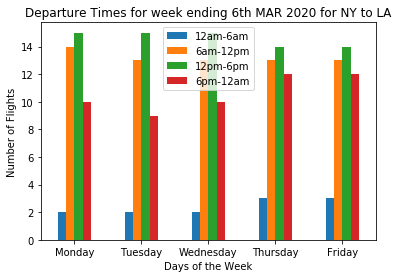

In [241]:
#FIXME implement in a function
monday    = airlines[airlines['flight_date'] == '2020-03-02']
tuesday   = airlines[airlines['flight_date'] == '2020-03-03']
wednesday = airlines[airlines['flight_date'] == '2020-03-04']
thursday  = airlines[airlines['flight_date'] == '2020-03-05']
friday    = airlines[airlines['flight_date'] == '2020-03-06']

mon_12am, mon_6am, mon_12pm, mon_6pm = day_time_data(monday)
tue_12am, tues_6am, tues_12pm, tues_6pm = day_time_data(tuesday)
wed_12am, wed_6am, wed_12pm, wed_6pm = day_time_data(wednesday)
thur_12am, thur_6am, thur_12pm, thur_6pm = day_time_data(thursday)
fri_12am, fri_6am, fri_12pm, fri_6pm = day_time_data(friday)


#What i want to do is print each day to a data frame like below but for each day, there is
midnight_df = [mon_12am, tue_12am, wed_12am, thur_12am, fri_12am]
six_am_df = [mon_6am, tues_6am, wed_6am, thur_6am, fri_6am]
midday_df = [mon_12pm, tues_12pm, wed_12pm, thur_12pm, fri_12pm]
six_pm_df = [mon_6pm, tues_6pm, wed_6pm, thur_6pm, fri_6pm]

NY_to_LA_times = pd.DataFrame({'12am-6am': midnight_df, '6am-12pm': six_am_df, \
                               '12pm-6pm': midday_df, '6pm-12am': six_pm_df}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

NY_plot = NY_to_LA_times.plot(kind='bar', title = 'Departure Times for week ending 6th MAR 2020 for NY to LA',\
                           rot=0)
NY_plot.set_xlabel("Days of the Week")
NY_plot.set_ylabel("Number of Flights")



As we can see now, the code has produce more of the flights and we can see that the total number of flights per week has been obtained.

Text(0, 0.5, 'Number of Flights')

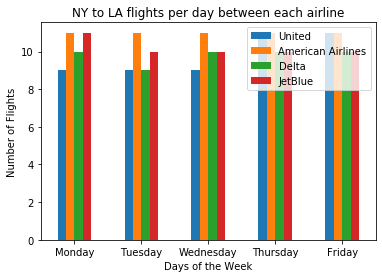

In [242]:
#FIXME i will now examine the different airlines and their flights per week
data = airlines.groupby(['airline.name', 'flight_date'])
ual_mon = data.get_group(('United Airlines', '2020-03-02'))
ual_tue = data.get_group(('United Airlines', '2020-03-03'))
ual_wed = data.get_group(('United Airlines', '2020-03-04'))
ual_thur = data.get_group(('United Airlines', '2020-03-05'))
ual_fri = data.get_group(('United Airlines', '2020-03-06'))
united_week = [ual_mon.shape[0], ual_tue.shape[0], ual_wed.shape[0], ual_thur.shape[0], ual_fri.shape[0]]

#FIXME THINK ABOUT SPLITTING THIS UP INTO A NUMBER OF VALUES
aa_mon = data.get_group(('American Airlines', '2020-03-02'))
aa_tue = data.get_group(('American Airlines', '2020-03-03'))
aa_wed = data.get_group(('American Airlines', '2020-03-04'))
aa_thur = data.get_group(('American Airlines', '2020-03-05'))
aa_fri = data.get_group(('American Airlines', '2020-03-06'))
american_week = [aa_mon.shape[0], aa_tue.shape[0], aa_wed.shape[0], aa_thur.shape[0], aa_fri.shape[0]]

delta_mon = data.get_group(('Delta Air Lines', '2020-03-02'))
delta_tue = data.get_group(('Delta Air Lines', '2020-03-03'))
delta_wed = data.get_group(('Delta Air Lines', '2020-03-04'))
delta_thur = data.get_group(('Delta Air Lines', '2020-03-05'))
delta_fri = data.get_group(('Delta Air Lines', '2020-03-06'))
delta_week = [delta_mon.shape[0], delta_tue.shape[0], delta_wed.shape[0], delta_thur.shape[0], delta_fri.shape[0]]

jetblue_mon = data.get_group(('JetBlue Airways', '2020-03-02'))
jetblue_tue = data.get_group(('JetBlue Airways', '2020-03-03'))
jetblue_wed = data.get_group(('JetBlue Airways', '2020-03-04'))
jetblue_thur = data.get_group(('JetBlue Airways', '2020-03-05'))
jetblue_fri = data.get_group(('JetBlue Airways', '2020-03-06'))
jetblue_week = [jetblue_mon.shape[0], jetblue_tue.shape[0], jetblue_wed.shape[0], jetblue_thur.shape[0], jetblue_fri.shape[0]]

flights_week = pd.DataFrame({'United': united_week, 'American Airlines': american_week, \
                               'Delta': delta_week, 'JetBlue': jetblue_week}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


week_plot = flights_week.plot(kind='bar', title = 'NY to LA flights per day between each airline', rot=0)
week_plot.set_xlabel("Days of the Week")
week_plot.set_ylabel("Number of Flights")



In [325]:
#FIXME talk about how the data for monday was wrong
#Next thing to do is to take all of the data and plot an individual airlines delays

Text(0, 0.5, 'Number of Delays per day')

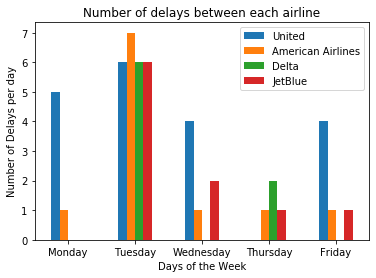

In [243]:
united_delays = [ual_mon['departure.delay'].count(), ual_tue['departure.delay'].count(), ual_wed['departure.delay'].count(), \
                ual_thur['departure.delay'].count(), ual_fri['departure.delay'].count()]

american_delays = [aa_mon['departure.delay'].count(), aa_tue['departure.delay'].count(), aa_wed['departure.delay'].count(), \
                aa_thur['departure.delay'].count(), aa_fri['departure.delay'].count()]

delta_delays = [delta_mon['departure.delay'].count(), delta_tue['departure.delay'].count(), delta_wed['departure.delay'].count(), \
                delta_thur['departure.delay'].count(), delta_fri['departure.delay'].count()]

jetblue_delays = [jetblue_mon['departure.delay'].count(), jetblue_tue['departure.delay'].count(), \
                  jetblue_wed['departure.delay'].count(), jetblue_thur['departure.delay'].count(),\
                  jetblue_fri['departure.delay'].count()]

delays_week = pd.DataFrame({'United': united_delays, 'American Airlines': american_delays, \
                               'Delta': delta_delays, 'JetBlue': jetblue_delays}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


delays_plot = delays_week.plot(kind='bar', title = 'Number of delays between each airline', rot=0)
delays_plot.set_xlabel("Days of the Week")
delays_plot.set_ylabel("Number of Delays per day")

FIXME Comment on the sudden spike in values on tuesday vs wednesday

In [244]:
delays_week

,United,American Airlines,Delta,JetBlue
Monday,5,1,0,0
Tuesday,6,7,6,6
Wednesday,4,1,0,2
Thursday,0,1,2,1
Friday,4,1,0,1


In [245]:
delays_week.describe()
#However, we cant make conclusive evidence about this, because a lot of the flights are either scheduled, active or landed 
#thus i need to filter for only the 

,United,American Airlines,Delta,JetBlue
count,5.000000,5.000000,5.000000,5.000000
mean,3.800000,2.200000,1.600000,2.000000
std,2.280351,2.683282,2.607681,2.345208
min,0.000000,1.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,1.000000
50%,4.000000,1.000000,0.000000,1.000000
75%,5.000000,1.000000,2.000000,2.000000
max,6.000000,7.000000,6.000000,6.000000


In [247]:
#I can examine the delays for say delta on Monday. It all says Nan but how about I look at the status
delta_mon['departure.delay']

4    NaN
6    NaN
10   NaN
14   NaN
18   NaN
22   NaN
25   NaN
29   NaN
32   NaN
37   NaN
Name: departure.delay, dtype: float64

In [248]:
#Then examine the flight statuses
delta_mon['flight_status']


4        landed
6        landed
10       landed
14       landed
18       active
22       active
25       active
29    scheduled
32    scheduled
37       landed
Name: flight_status, dtype: object

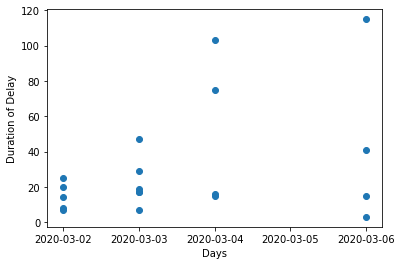

,Monday,Tuesday,Wednesday,Thursday,Friday
count,5.000000,6.000000,4.000000,0.0,4.000000
mean,14.800000,22.666667,52.250000,NaN,43.500000
std,7.726578,13.822687,43.949782,NaN,50.236109
min,7.000000,7.000000,15.000000,NaN,3.000000
25%,8.000000,17.000000,15.750000,NaN,12.000000
50%,14.000000,18.000000,45.500000,NaN,28.000000
75%,20.000000,26.500000,82.000000,NaN,59.500000
max,25.000000,47.000000,103.000000,NaN,115.000000


In [318]:
#To learn more about these delays, I will make a data frame out of each of them

united = pd.DataFrame({'Monday': ual_mon['departure.delay'], 'Tuesday': ual_tue['departure.delay'], \
                               'Wednesday': ual_wed['departure.delay'], 'Thursday': ual_thur['departure.delay'],\
                            'Friday': ual_fri['departure.delay']})

united_days = pd.concat([ual_mon, ual_tue, ual_wed, ual_thur, ual_fri])
X = united_days['flight_date']
Y = united_days['departure.delay']
united_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()
united.describe()

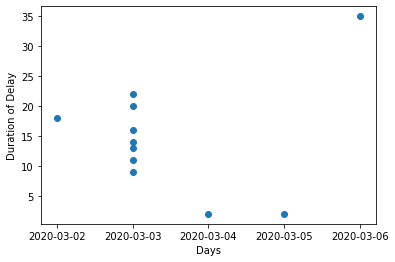

,Monday,Tuesday,Wednesday,Thursday,Friday
count,1.0,7.000000,1.0,1.0,1.0
mean,18.0,15.000000,2.0,2.0,35.0
std,NaN,4.690416,NaN,NaN,NaN
min,18.0,9.000000,2.0,2.0,35.0
25%,18.0,12.000000,2.0,2.0,35.0
50%,18.0,14.000000,2.0,2.0,35.0
75%,18.0,18.000000,2.0,2.0,35.0
max,18.0,22.000000,2.0,2.0,35.0


In [320]:
american = pd.DataFrame({'Monday': aa_mon['departure.delay'], 'Tuesday': aa_tue['departure.delay'], \
                               'Wednesday': aa_wed['departure.delay'], 'Thursday': aa_thur['departure.delay'],\
                            'Friday': aa_fri['departure.delay']})



aa_days = pd.concat([aa_mon, aa_tue, aa_wed, aa_thur, aa_fri])
X = aa_days['flight_date']
Y = aa_days['departure.delay']
aa_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()

american.describe()


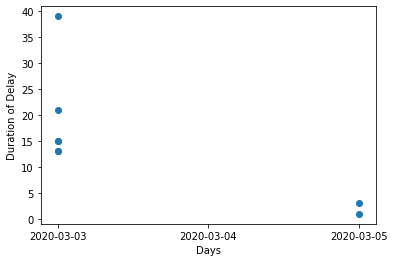

,Monday,Tuesday,Wednesday,Thursday,Friday
count,0.0,6.000000,0.0,2.000000,0.0
mean,NaN,19.333333,NaN,2.000000,NaN
std,NaN,10.073066,NaN,1.414214,NaN
min,NaN,13.000000,NaN,1.000000,NaN
25%,NaN,13.500000,NaN,1.500000,NaN
50%,NaN,15.000000,NaN,2.000000,NaN
75%,NaN,19.500000,NaN,2.500000,NaN
max,NaN,39.000000,NaN,3.000000,NaN


In [321]:
delta = pd.DataFrame({'Monday': delta_mon['departure.delay'], 'Tuesday': delta_tue['departure.delay'], \
                               'Wednesday': delta_wed['departure.delay'], 'Thursday': delta_thur['departure.delay'],\
                            'Friday': delta_fri['departure.delay']})

delta_days = pd.concat([delta_mon, delta_tue, delta_wed, delta_thur, delta_fri])
X = delta_days['flight_date']
Y = delta_days['departure.delay']
delta_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()

delta.describe()
#There was no delays on wednesday or friday hence the difference

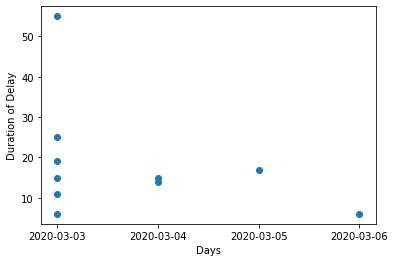

,Monday,Tuesday,Wednesday,Thursday,Friday
count,0.0,6.000000,2.000000,1.0,1.0
mean,NaN,21.833333,14.500000,17.0,6.0
std,NaN,17.509045,0.707107,NaN,NaN
min,NaN,6.000000,14.000000,17.0,6.0
25%,NaN,12.000000,14.250000,17.0,6.0
50%,NaN,17.000000,14.500000,17.0,6.0
75%,NaN,23.500000,14.750000,17.0,6.0
max,NaN,55.000000,15.000000,17.0,6.0


In [322]:
jetblue = pd.DataFrame({'Monday': jetblue_mon['departure.delay'], 'Tuesday': jetblue_tue['departure.delay'], \
                               'Wednesday': jetblue_wed['departure.delay'], 'Thursday': jetblue_thur['departure.delay'],\
                            'Friday': jetblue_fri['departure.delay']})


jetblue_days = pd.concat([jetblue_mon, jetblue_tue, jetblue_wed, jetblue_thur, jetblue_fri])
X = jetblue_days['flight_date']
Y = jetblue_days['departure.delay']
jetblue_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()


jetblue.describe()

In [324]:
total_delays = pd.concat([united, american, delta, jetblue])
total_delays
total_delays.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday
count,6.000000,25.000000,7.000000,4.000000,6.000000
mean,15.333333,19.520000,34.285714,5.750000,35.833333
std,7.033254,11.836103,38.538787,7.544314,41.705715
min,7.000000,6.000000,2.000000,1.000000,3.000000
25%,9.500000,13.000000,14.500000,1.750000,8.250000
50%,16.000000,16.000000,15.000000,2.500000,25.000000
75%,19.500000,21.000000,45.500000,6.500000,39.500000
max,25.000000,55.000000,103.000000,17.000000,115.000000


Next thing to do is to do the most popular airlines each week in terms of departures and then do their delays. 
So do a similar plot to above but instead of times, do airlines

Talk about how there is a massive spike in delays on tuesday......WHY IS THAT.....COMPARE THE WEATHER TO MAKE IT BETTER

In [ ]:
#Correlate the weather for the week and the delays in the US

#Correlate the weather witht he Irish departures and correlate the delay with a good day vs storm Jorge


## Using a Second API: WorldWeatherOnline
As we have seen by the above plots regarding the delays from New York to Los Angeles, there was a sudden spike in the number of delays on the Tuesday of the week (3rd March 2020). To see if these delays had any correlation with the weather in terms of high winds or rain. As we all know, weather is the number one cause of delays for flights ranging from blizzards, high winds or storms. I will use the WorldWeatherOnline Weather API where I was given a trial until the end of April. 
In terms of data, I have already mentuoned that the historical data is forecast data. This suits me fine as I can filter by hourly, 3-hourly or daily forecast data to make conclusions about the flights during that day.
In terms of comparisons, I will use it initially with the US flight data from New York to Los Angeles and then I will use it with the data originally gathered from Dublin Airport for calm and stormy days. For example, I managed to obtain data on the 29th of February for Dublin Airport which is the day that Storm Jorge hit Ireland. 